In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import PIL
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip -q install faiss-cpu datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 71.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 32.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.3 MB/s eta 0:00:00


In [3]:
!git clone https://github.com/Raiden-Makoto/Genshinfy-UwU

Cloning into 'Genshinfy-UwU'...
remote: Enumerating objects: 182, done.
remote: Counting objects: 100% (182/182), done.
remote: Compressing objects: 100% (172/172), done.
remote: Total 182 (delta 38), reused 129 (delta 9), pack-reused 0 (from 0)
Receiving objects: 100% (182/182), 37.27 MiB | 20.08 MiB/s, done.
Resolving deltas: 100% (38/38), done.


In [4]:
%cd Genshinfy-UwU

/content/Genshinfy-UwU


In [5]:
import torch
from torch.utils.data import DataLoader
from datasets import Dataset
from datasets import Image as IMG
from typing import List, Union, Tuple
from transformers import CLIPProcessor, CLIPModel

import faiss
import glob

In [6]:
img_path = './GenshinCharacters'
img_files = glob.glob(img_path + "/*.[jJpP][pPnN][gG]")

In [7]:
img_files = sorted(img_files)
print(f"There are {len(img_files)} images.")

There are 92 images.


In [8]:
device = "cpu"
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [9]:
def encode_images(
    images: Union[List[str], List[PIL.Image.Image]],
    batch_size: int
):
    def transform_func(x):
        if isinstance(x['image'], PIL.Image.Image):
            image = x['image']
        else:
            image = [IMG().decode_example(img) for img in x['image']]
        return processor(images=image, return_tensors='pt')

    dataset = Dataset.from_dict({'image' : images})
    dataset = dataset.cast_column('image', IMG(decode=False)) \
                if isinstance(images[0], str) \
                else dataset
    dataset.set_format('torch')
    dataset.set_transform(transform_func)
    dataloader = DataLoader(dataset, batch_size=batch_size)
    image_embeddings = []
    progress = tqdm(total=len(images)//batch_size, position=0)

    with torch.no_grad():
        for batch in dataloader:
            batch = {k : v.to(device) for k,v in batch.items()}
            image_embeddings.extend(
                model.get_image_features(**batch).detach().cpu().numpy()
            )
            progress.update(1)
        progress.close()
    return np.stack(image_embeddings)

In [10]:
vector_embedding = np.array(encode_images(img_files, 7))

14it [00:12,  1.15it/s]


In [11]:
# Store Embeddings
with open('vector_embedding.pkl', 'wb') as f:
    pickle.dump(vector_embedding, f)

In [12]:
indexer = faiss.IndexFlatIP(vector_embedding.shape[1]) #inner product similarity
indexer.add(vector_embedding)

In [25]:
def encode_text(
    text: List[str],
    batch_size: int
):
    dev = "cpu"
    dataset = Dataset.from_dict({'text' : text})
    dataset = dataset.map(
        lambda x: processor(
            text = x['text'],
            padding = True,
            return_tensors = 'pt',
            max_length = 77,
            truncation = True,
        ),
        batched=True,
        batch_size=batch_size
    )
    dataset.set_format(type="torch", columns=["input_ids", "attention_mask"])
    dataloader = DataLoader(dataset, batch_size=batch_size)
    text_embeddings = []
    progress = tqdm(total=len(text) // batch_size, position=0)

    with torch.no_grad():
        for batch in dataloader:
            batch = {
                k : v.to(dev) if isinstance(v, torch.Tensor) else torch.tensor(v).to(dev)
                for k,v in batch.items()
            }
            text_embeddings.extend(
                model.get_text_features(**batch).detach().cpu().numpy()
            )
            progress.update(1)
        progress.close()
    return np.stack(text_embeddings)


In [26]:
search_text = input("Enter some text: ").strip()

Enter some text: kitten


In [27]:
with torch.no_grad():
    search_results = encode_text([search_text], batch_size=7)
search_restuls = search_results / np.linalg.norm(search_results, ord=2, axis=-1, keepdims=True)

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

1it [00:00, 10.39it/s]


In [29]:
#search potential images
distances, indices = indexer.search(search_results.reshape(1, -1), k=5)

In [30]:
distances, indices = distances[0], indices[0]
indices_to_distance = list(zip(indices, distances))
indices_to_distance.sort(key=lambda x: x[1]) #distance-based sort

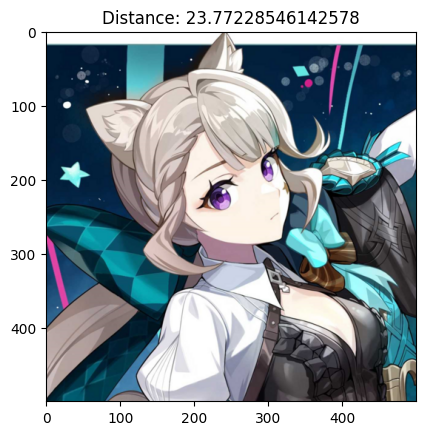

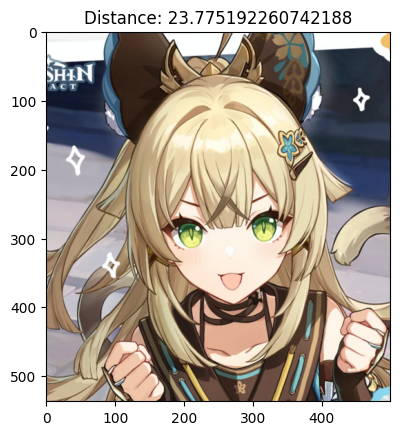

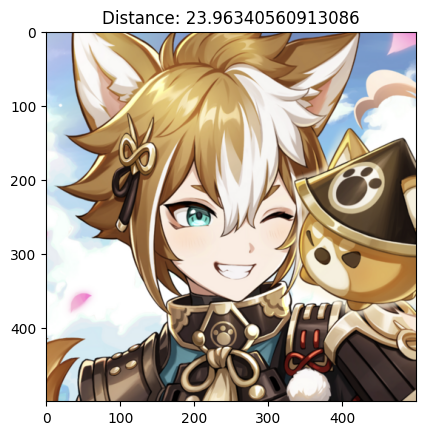

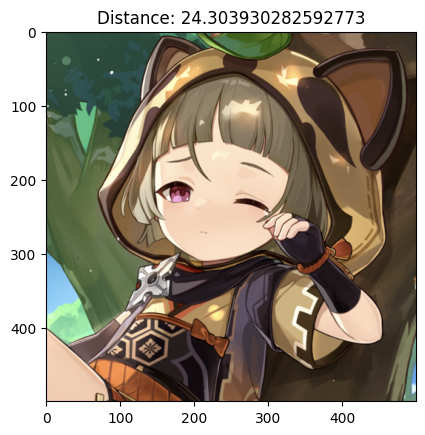

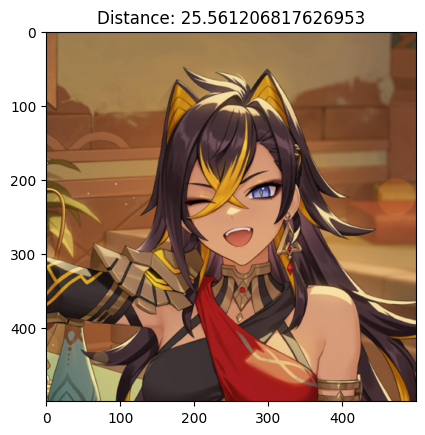

In [31]:
for idx, distance in indices_to_distance:
    path = img_files[idx]
    im = PIL.Image.open(path)
    plt.imshow(im)
    plt.title(f"Distance: {distance}")
    plt.show()